In [1]:
import pandas as pd 
import numpy as np
import re
import random
import math
from bs4 import BeautifulSoup
import os

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model

import bert

In [3]:
tf.test.gpu_device_name() 

'/device:GPU:0'

In [4]:
print(tf.__version__)

2.1.0


In [5]:
# Load all files from a directory into dictionaries
def load_directory_data(directory, label):
    data = []
    for file_path in os.listdir(directory):
        with open(os.path.join(directory, file_path), "r") as f:
            data.append({"text": f.read().replace("<br />", " "), "label": label})
    return data

# Load the positive and negative examples from the dataset
def load_dataset(directory):
    pos_data = load_directory_data(os.path.join(directory, "pos"), 1)
    neg_data = load_directory_data(os.path.join(directory, "neg"), 0)
    return pos_data+neg_data

In [6]:
train_data = load_dataset(os.path.join(os.path.dirname("F:\\Projects\\CA-5\\"), "aclImdb", "train"))

In [7]:
test_data = load_dataset(os.path.join(os.path.dirname("F:\\Projects\\CA-5\\"), "aclImdb", "test"))

In [8]:
random.shuffle(train_data)
random.shuffle(test_data)

In [9]:
print(len(train_data))
print(len(test_data))

25000
25000


In [10]:
print("len of shotest text of train_data: ", min(len(x['text']) for x in train_data ))
print("len of longest text of train_data: ", max(len(x['text']) for x in train_data ))

print("\nlen of shotest text of test_data: ", min(len(x['text']) for x in test_data ))
print("len of longest text of test_data: ", max(len(x['text']) for x in test_data ))

len of shotest text of train_data:  52
len of longest text of train_data:  13604

len of shotest text of test_data:  32
len of longest text of test_data:  12730


In [11]:
def denoise_text(text):    
    # Remove the html strips
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # Remove digits and punctuations 
    pattern=r'[^a-zA-Z]'
    text=re.sub(pattern,' ',text)
    
    # Remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
        
    return text

In [12]:
train_X, train_Y, test_X, test_Y = [], [], [], []

for e in train_data:
    train_X.append(denoise_text(e['text']))
    train_Y.append(e['label'])
    
for e in test_data:
    test_X.append(denoise_text(e['text']))
    test_Y.append(e['label'])      

In [13]:
#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
bert_layer = hub.KerasLayer("F:\\Projects\\bertmodel", trainable=False)

In [14]:
BertTokenizer=bert.bert_tokenization.FullTokenizer
 
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
 
tokenizer=BertTokenizer(vocab_file,do_lower_case)

In [15]:
print(tokenizer.tokenize("I don't like this movie"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I don't like this movie")))

['I', 'don', "'", 't', 'like', 'this', 'movie']
[146, 1274, 112, 189, 1176, 1142, 2523]


In [16]:
def get_ids_masks_segs(tokens, tokenizer, max_seq_length):
    
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
            
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    if len(token_ids) < max_seq_length:
        input_ids = token_ids + [0] * (max_seq_length - len(token_ids))
        masks = [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
        segments = segments + [0] * (max_seq_length - len(tokens))
    else:
        input_ids = token_ids[:max_seq_length]
        masks = [1] * max_seq_length
        segments = segments[:max_seq_length]
    
    return input_ids, masks, segments

In [17]:
from tqdm import tqdm
MAX_SEQ_LEN = 128
def create_input_array(sentences):
    
    input_ids, input_masks, input_segments = [], [], []

    for sentence in sentences: # tqdm(sentences, position=0, leave=True):
        tokens = tokenizer.tokenize(sentence)  
        tokens = tokens[:MAX_SEQ_LEN-2]
  
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        ids, masks, segments = get_ids_masks_segs(tokens, tokenizer, MAX_SEQ_LEN)        

        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [18]:
inputs = create_input_array(train_X)

In [19]:
print(inputs[0].shape)
print(inputs[1].shape)
print(inputs[2].shape)

print(inputs[0][10])
print(inputs[1][10])
print(inputs[2][10])

(25000, 128)
(25000, 128)
(25000, 128)
[  101  1332  6910  1115  6727   160 12415  1105 11173 20452  8167 13040
  1197  1127  1107  1103  1269  2523  1108  1176  2794  5890  1108  9582
  1106  1267  1103  2523  1262  1138  1106  1474  1103  1148  5147  1904
  1137  1177  1127  1185 19760 11007  1107  1236  1599  1122  1355  1155
  1205  4665  1238  5363  1122  1106  1129 17549  1104 10966  5663  2987
  2266 23993  4043   179  1818  4043  1220  1261  1451  1936  6241  8366
  1105  3885  1122  1154  1141  4736  1642  1108 12647 22096  1181  1115
  6727  1108  2017  1107  1625  1104  1103  3271  2108  1117  1648  9913
  1114  3106  8458  3575  1156  2140  4392  1155  1115 11074  1164  1103
  4357  1414  1409  2256  1541  3349  1106  1221  1293  3291  6262 19782
  6602  1108  1176  3465  1205  1105  2373   102]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [20]:
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")

In [21]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [22]:
print(sequence_output.shape)
print(pooled_output.shape)

(None, None, 1024)
(None, 1024)


In [23]:
hidden_units = 1024
learning_rate = 0.0002

x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(units=hidden_units, activation='sigmoid')(x)
x = tf.keras.layers.Dense(units=hidden_units, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
out = tf.keras.layers.Dense(units=1, activation="sigmoid", name="dense_output")(x)
 
model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [25]:
model_name="model_imdb_bert_classifier.hdf5" 
#checkpointer = ModelCheckpoint(model_name, monitor='loss', save_best_only=True, mode='min')
checkpointer = ModelCheckpoint(model_name, monitor='loss')
history = model.fit(inputs, np.array(train_Y), epochs=10, batch_size=32, 
                    validation_split=0.2, shuffle=True, callbacks=[checkpointer])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 574s 29ms/sample - loss: 0.9346 - accuracy: 0.8212 - val_loss: 0.6997 - val_accuracy: 0.8350
Epoch 2/10
20000/20000 [==============================] - 558s 28ms/sample - loss: 0.6084 - accuracy: 0.8444 - val_loss: 0.5484 - val_accuracy: 0.8486
Epoch 3/10
20000/20000 [==============================] - 560s 28ms/sample - loss: 0.5112 - accuracy: 0.8461 - val_loss: 0.5003 - val_accuracy: 0.8334
Epoch 4/10
20000/20000 [==============================] - 560s 28ms/sample - loss: 0.4610 - accuracy: 0.8480 - val_loss: 0.5019 - val_accuracy: 0.8202
Epoch 5/10
20000/20000 [==============================] - 554s 28ms/sample - loss: 0.4299 - accuracy: 0.8517 - val_loss: 0.4078 - val_accuracy: 0.8604
Epoch 6/10
20000/20000 [==============================] - 559s 28ms/sample - loss: 0.4105 - accuracy: 0.8487 - val_loss: 0.3963 - val_accuracy: 0.8560
Epoch 7/10
20000/20000 [=====================

In [26]:
history.history['val_loss']

[0.6997118298530579,
 0.5483793245315551,
 0.5002860488891602,
 0.5019387849330902,
 0.40775084857940674,
 0.39633674602508545,
 0.38584960789680484,
 0.37861419858932494,
 0.37201654443740845,
 0.3649319619178772]

In [27]:
trfile = open('imdb_bert_train_10.csv', "ab")    
np.savetxt(trfile, [history.history['loss'], history.history['val_loss']], fmt="%2.6f",delimiter=",")
#np.savetxt(trfile, history.history['val_loss'], fmt="%2.6f",delimiter=",")
trfile.close()

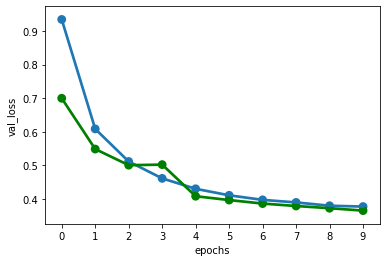

In [28]:
import seaborn as sns
import pandas as pd 

df_result = pd.DataFrame({'epochs':history.epoch, 
                          'loss': history.history['loss'], 
                          'val_loss': history.history['val_loss']})

g = sns.pointplot(x="epochs", y="loss", data=df_result, fit_reg=False)

g = sns.pointplot(x="epochs", y="val_loss", data=df_result, fit_reg=False, color='green')

In [52]:
test_inputs=create_input_array(test_X)

In [53]:
results = model.predict(test_inputs)

In [54]:
pred_Y=[]
for i in range(len(results)):
    if results[i] >= 0.5:
        pred_Y.append(1)
    else:
        pred_Y.append(0)      

In [55]:
res = []
for i in range(len(test_Y)):
    res.append([test_Y[i],pred_Y[i]])


In [33]:
trfile = open('imdb_bert_test_10.csv', "ab")    
np.savetxt(trfile, res, fmt="%2.6f",delimiter=",")
trfile.close()

In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.8550399999999999

In [36]:

print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.85504
recall :  0.85504
f1_score :  0.85504
accuracy_score :  0.85504


In [37]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.855411256343138
recall :  0.85504
f1_score :  0.8550021344454011
accuracy_score :  0.85504


In [61]:
#for i in range(len(pred_Y)):
#    print(test_Y[i], pred_Y[i])

In [38]:
model_name="model_imdb_bert_classifier.hdf5" 
#checkpointer = ModelCheckpoint(model_name, monitor='loss', save_best_only=True, mode='min')
checkpointer = ModelCheckpoint(model_name, monitor='loss')
history = model.fit(inputs, np.array(train_Y), epochs=10, batch_size=32, 
                    validation_split=0.2, shuffle=True, callbacks=[checkpointer])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 554s 28ms/sample - loss: 0.3693 - accuracy: 0.8576 - val_loss: 0.3765 - val_accuracy: 0.8512
Epoch 2/10
20000/20000 [==============================] - 556s 28ms/sample - loss: 0.3665 - accuracy: 0.8558 - val_loss: 0.3732 - val_accuracy: 0.8548
Epoch 3/10
20000/20000 [==============================] - 556s 28ms/sample - loss: 0.3643 - accuracy: 0.8555 - val_loss: 0.3677 - val_accuracy: 0.8564
Epoch 4/10
20000/20000 [==============================] - 556s 28ms/sample - loss: 0.3573 - accuracy: 0.8607 - val_loss: 0.3752 - val_accuracy: 0.8478
Epoch 5/10
20000/20000 [==============================] - 556s 28ms/sample - loss: 0.3569 - accuracy: 0.8590 - val_loss: 0.3724 - val_accuracy: 0.8484
Epoch 6/10
20000/20000 [==============================] - 558s 28ms/sample - loss: 0.3553 - accuracy: 0.8596 - val_loss: 0.3615 - val_accuracy: 0.8592
Epoch 7/10
20000/20000 [=====================

In [39]:
trfile = open('imdb_bert_train_20.csv', "ab")    
np.savetxt(trfile, [history.history['loss'], history.history['val_loss']], fmt="%2.6f",delimiter=",")
#np.savetxt(trfile, history.history['val_loss'], fmt="%2.6f",delimiter=",")
trfile.close()

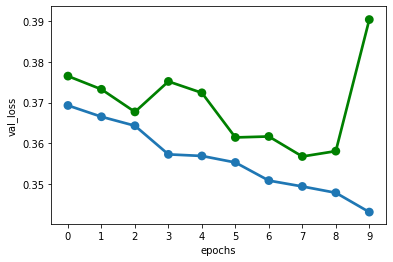

In [40]:
import seaborn as sns
import pandas as pd 

df_result = pd.DataFrame({'epochs':history.epoch, 
                          'loss': history.history['loss'], 
                          'val_loss': history.history['val_loss']})

g = sns.pointplot(x="epochs", y="loss", data=df_result, fit_reg=False)

g = sns.pointplot(x="epochs", y="val_loss", data=df_result, fit_reg=False, color='green')

In [45]:
trfile = open('imdb_bert_test_20.csv', "ab")    
np.savetxt(trfile, res, fmt="%2.6f",delimiter=",")
trfile.close()

In [46]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.8357199999999999

In [47]:
print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.83572
recall :  0.83572
f1_score :  0.83572
accuracy_score :  0.83572


In [48]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.8443333562139491
recall :  0.83572
f1_score :  0.8346861858613415
accuracy_score :  0.83572


In [49]:
model_name="model_imdb_bert_classifier.hdf5" 
#checkpointer = ModelCheckpoint(model_name, monitor='loss', save_best_only=True, mode='min')
checkpointer = ModelCheckpoint(model_name, monitor='loss')
history = model.fit(inputs, np.array(train_Y), epochs=30, batch_size=32, 
                    validation_split=0.2, shuffle=True, callbacks=[checkpointer])

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 553s 28ms/sample - loss: 0.3431 - accuracy: 0.8639 - val_loss: 0.3605 - val_accuracy: 0.8584
Epoch 2/30
20000/20000 [==============================] - 557s 28ms/sample - loss: 0.3402 - accuracy: 0.8666 - val_loss: 0.3507 - val_accuracy: 0.8652
Epoch 3/30
20000/20000 [==============================] - 559s 28ms/sample - loss: 0.3388 - accuracy: 0.8665 - val_loss: 0.3529 - val_accuracy: 0.8662
Epoch 4/30
20000/20000 [==============================] - 559s 28ms/sample - loss: 0.3343 - accuracy: 0.8701 - val_loss: 0.3604 - val_accuracy: 0.8540
Epoch 5/30
20000/20000 [==============================] - 556s 28ms/sample - loss: 0.3354 - accuracy: 0.8681 - val_loss: 0.3981 - val_accuracy: 0.8276
Epoch 6/30
20000/20000 [==============================] - 554s 28ms/sample - loss: 0.3320 - accuracy: 0.8722 - val_loss: 0.3516 - val_accuracy: 0.8624
Epoch 7/30
20000/20000 [=====================

In [50]:
trfile = open('imdb_bert_train_50.csv', "ab")    
np.savetxt(trfile, [history.history['loss'], history.history['val_loss']], fmt="%2.6f",delimiter=",")
#np.savetxt(trfile, history.history['val_loss'], fmt="%2.6f",delimiter=",")
trfile.close()

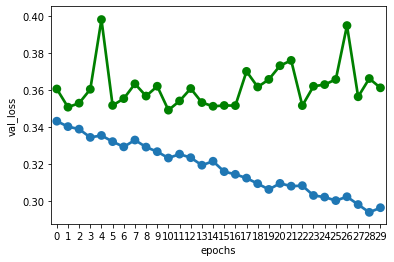

In [51]:
import seaborn as sns
import pandas as pd 

df_result = pd.DataFrame({'epochs':history.epoch, 
                          'loss': history.history['loss'], 
                          'val_loss': history.history['val_loss']})

g = sns.pointplot(x="epochs", y="loss", data=df_result, fit_reg=False)

g = sns.pointplot(x="epochs", y="val_loss", data=df_result, fit_reg=False, color='green')

In [56]:
trfile = open('imdb_bert_test_50.csv', "ab")    
np.savetxt(trfile, res, fmt="%2.6f",delimiter=",")
trfile.close()

In [57]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.85288

In [58]:

print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.85288
recall :  0.85288
f1_score :  0.85288
accuracy_score :  0.85288


In [59]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.8529335691041592
recall :  0.8528800000000001
f1_score :  0.8528744172314865
accuracy_score :  0.85288
